# Problem description
This is my take on an introductory Kaggle Competition: https://www.kaggle.com/c/titanic/ <br>
I will be using Keras (on Tenserflow) to solve this problem.<br>

This is binary classification problem, I'll be using binary crossentropy loss function, with sigmoid activation on last network layer. Also data will require some preprocessing before it's usable for Deep Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers

%matplotlib inline

Using TensorFlow backend.


#### Meet and greet data

In [2]:
train_ds = pd.read_csv('train.csv')
test_ds = pd.read_csv('test.csv')

In [3]:
print(f"Train data shape: {train_ds.shape}")
print(f"Test data shape: {test_ds.shape}")
train_ds.sample(10)

Train data shape: (891, 12)
Test data shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
468,469,0,3,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q
113,114,0,3,"Jussila, Miss. Katriina",female,20.0,1,0,4136,9.8250,NaN,S
657,658,0,3,"Bourke, Mrs. John (Catherine)",female,32.0,1,1,364849,15.5000,NaN,Q
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,NaN,Q
719,720,0,3,"Johnson, Mr. Malkolm Joackim",male,33.0,0,0,347062,7.7750,NaN,S
520,521,1,1,"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,S
423,424,0,3,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...",female,28.0,1,1,347080,14.4000,NaN,S
730,731,1,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q


In [4]:
print("          Data summary")
print(train_ds.info())
print('='*40)
print("          NaN values summary")
print("--- Train data: ")
print(train_ds.isnull().sum())
print("--- Test data: ")
print(test_ds.isnull().sum())

          Data summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
          NaN values summary
--- Train data: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--- Test data: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age     

In [5]:
dataset_cleaner = [train_ds, test_ds]
drop_columns = ['Cabin', 'PassengerId','Ticket']
for dataset in dataset_cleaner:
    dataset.drop(drop_columns, axis = 1, inplace = True)
    dataset['Age'].fillna(dataset['Age'].mean(), inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

In [6]:
train_ds.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [7]:
train_ds.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
356,1,1,"Bowerman, Miss. Elsie Edith",female,22.000000,0,1,55.0000,S
388,0,3,"Sadlier, Mr. Matthew",male,29.699118,0,0,7.7292,Q
49,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.000000,1,0,17.8000,S
359,1,3,"Mockler, Miss. Helen Mary ""Ellie""",female,29.699118,0,0,7.8792,Q
292,0,2,"Levy, Mr. Rene Jacques",male,36.000000,0,0,12.8750,C


#### now I need to encode qualitative data for use in neural network

In [8]:
for dataset in dataset_cleaner:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
title_names = (train_ds['Title'].value_counts() < 10)

In [9]:
for dataset in dataset_cleaner:
    dataset['Title'] = dataset['Title'].apply(lambda x: 'Misc' if (x not in title_names) or (title_names.loc[x]) else x)
    dataset.drop(['Name'], axis = 1, inplace = True)

In [10]:
test_ds['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64

In [11]:
train_ds.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
721,0,3,male,17.0,1,0,7.0542,S,Mr
142,1,3,female,24.0,1,0,15.8500,S,Mrs
134,0,2,male,25.0,0,0,13.0000,S,Mr
378,0,3,male,20.0,0,0,4.0125,C,Mr
234,0,2,male,24.0,0,0,10.5000,S,Mr


From now on I'll work on copy of dataset for various experiments with encoding

In [12]:
def copy_dataset():
    train_data = train_ds.drop(['Survived'], axis = 1).copy(deep = True)
    train_targets = train_ds['Survived'].copy(deep = True)
    test_data = test_ds.copy(deep = True)
    return (train_data, train_targets, test_data)

In [13]:
from sklearn.preprocessing import LabelEncoder

train_data, train_targets, test_data = copy_dataset()
dataset_cleaner = [train_data,test_data]

label = LabelEncoder()
for dataset in dataset_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset.drop(['Sex', 'Embarked', 'Title'], axis = 1, inplace = True)

In [14]:
test_data.sample(5)

,Pclass,Age,SibSp,Parch,Fare,Sex_Code,Embarked_Code,Title_Code
212,2,17.00000,0,0,73.5000,1,2,3
265,3,30.27259,0,0,7.8958,1,2,3
0,3,34.50000,0,0,7.8292,1,1,3
329,2,21.00000,0,0,13.0000,1,2,3
131,1,53.00000,0,0,28.5000,1,0,1


# Experiment 1

Let's split data and normalize :)

In [15]:
for dataset in dataset_cleaner:
    mean = dataset.mean()
    std = dataset.std()
    dataset -= mean
    dataset /= std

In [16]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation = 'relu', input_shape = (train_data.shape[1], )))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

We don't really have that much data for training, so let's use K-Fold validation.

In [17]:
def test_model(k = 4, model_builder=build_model):
    k = 4
    num_val_samples = train_data.shape[0] // k
    num_epochs = 30
    all_history = []

    for i in range(k):
        print(f"processing fold #{i}")
        val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
        val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

        partial_train_data = np.concatenate([train_data[0:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis = 0)
        partial_train_targets = np.concatenate([train_targets[0:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis = 0)

        model = model_builder()
        history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1,
                           validation_data = (val_data, val_targets), verbose = 0)
        all_history.append(history)
    return all_history

In [18]:
def prepare_plot_data(history):
    
    def mean_history(histories, column):
        array = np.array([x.history[column] for x in histories])
        average = np.mean(array, axis = 0)
        return average

    average_val_loss = mean_history(history, 'val_loss')
    average_loss = mean_history(history, 'loss')
    average_acc = mean_history(history, 'acc')
    average_val_acc = mean_history(history, 'val_acc')
    return (average_loss, average_val_loss, average_acc, average_val_acc)

In [19]:
def plot_loss(avg_loss, avg_val_loss):
    plt.clf()
    plt.plot(range(len(avg_loss)), avg_loss, 'bo', label = 'Training loss')
    plt.plot(range(len(avg_val_loss)), avg_val_loss, 'b', label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [20]:
def plot_acc(avg_acc, avg_val_acc):
    plt.clf()
    plt.plot(range(len(avg_acc)), avg_acc, 'bo', label = 'Training accuracy')
    plt.plot(range(len(avg_val_acc)), avg_val_acc, 'b', label = 'Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [21]:
all_history = test_model(model_builder = build_model)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


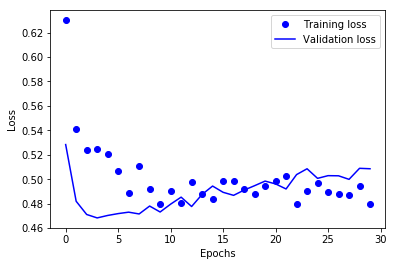

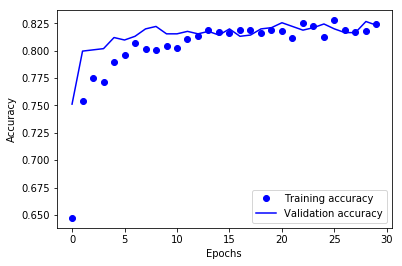

In [22]:
avg_loss, avg_val_loss, avg_acc, avg_val_acc = prepare_plot_data(all_history)
plot_loss(avg_loss, avg_val_loss)
plot_acc(avg_acc, avg_val_acc)

In [23]:
model = build_model()
model.fit(train_data, train_targets, epochs = 20, batch_size = 1, verbose = 0)

891/891 [==============================] - 0s 316us/step
[0.42417122281494096, 0.8383838379155639]
AUC: 0.8820103537532356


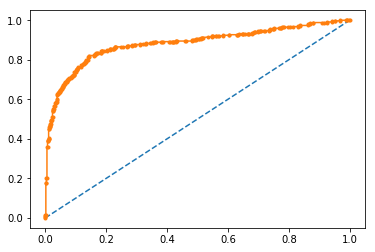

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

print(model.evaluate(train_data, train_targets))
predict = model.predict(train_data)

auc = roc_auc_score(train_targets, predict)
print (f"AUC: {auc}")
fpr, tpr, thresholds = roc_curve(train_targets, predict)

plt.plot([0,1], [0,1], linestyle = '--')
plt.plot(fpr, tpr, marker = '.')
plt.show()

          fpr       tpr     1-fpr        tf  thresholds
121  0.167577  0.833333  0.832423  0.000911    0.200595


[]

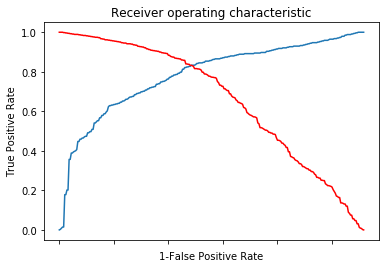

In [25]:
i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index = i), 'tpr': pd.Series(tpr, index = i),
                   '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i),
                   'thresholds': pd.Series(thresholds, index = i)})
print(roc.iloc[(roc.tf-0).abs().argsort()[:1]])

fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [26]:
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
121,0.167577,0.833333,0.832423,0.000911,0.200595


In [27]:
result = model.predict(test_data)
cutoff = 0.40

results = pd.DataFrame([0 if result[x] < cutoff else 1 for x in range(len(result))], columns = ['Survived'])
submittion = pd.read_csv('test.csv', usecols=[0])
submittion = pd.concat([submittion, results], axis = 1)
submittion.to_csv("submittion_1.csv", index = False, encoding = 'utf-8')

Interesting note: after submitting this file with a cutoff point set at 0.5, my accuracy was at 77.99%.
With cutoff point set to 0.4, my accuracy was 78.94%

# Experiment 2
one-hot encoding the data

In [28]:
train_data, train_targets, test_data = copy_dataset()

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def process(dataset):
    columns_to_standardize = ['Age','SibSp','Parch', 'Fare']
    dataset = pd.get_dummies(dataset, columns = ['Pclass', 'Sex', 'Embarked', 'Title'], sparse = False)
    dataset[columns_to_standardize] = dataset[columns_to_standardize].astype('float64')
    dataset[columns_to_standardize] = scaler.fit_transform(dataset[columns_to_standardize])
    return dataset

In [30]:
train_data = process(train_data)
test_data = process(test_data)

In [31]:
print(f"Train data shape: {train_data.shape}")
train_data.sample(5)

Train data shape: (891, 17)


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
102,-0.669435,-0.474545,0.767630,0.907738,1,0,0,0,1,0,0,1,0,0,0,1,0
392,-0.130754,1.340132,-0.473674,-0.488854,0,0,1,0,1,0,0,1,0,0,0,1,0
5,0.000000,-0.474545,-0.473674,-0.478116,0,0,1,0,1,0,1,0,0,0,0,1,0
576,0.330972,-0.474545,-0.473674,-0.386671,0,1,0,1,0,0,0,1,0,0,1,0,0
406,1.639196,-0.474545,-0.473674,-0.492378,0,0,1,0,1,0,0,1,0,0,0,1,0


In [32]:
all_history = test_model(model_builder = build_model)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


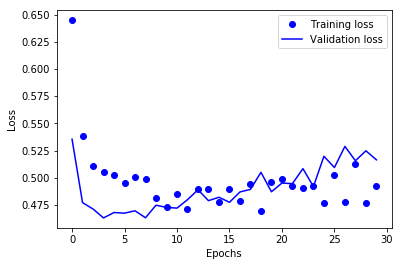

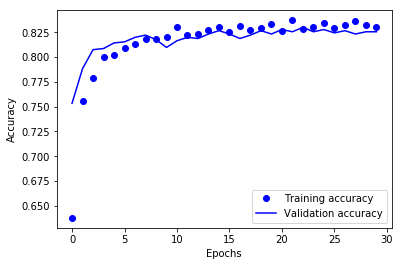

In [33]:
avg_loss, avg_val_loss, avg_acc, avg_val_acc = prepare_plot_data(all_history)
plot_loss(avg_loss, avg_val_loss)
plot_acc(avg_acc, avg_val_acc)

In [34]:
model = build_model()
model.fit(train_data, train_targets, epochs = 20, batch_size = 1, verbose = 0)

891/891 [==============================] - 0s 537us/step
[0.4674558602064413, 0.8462401791052385]
AUC: 0.8860501283567145


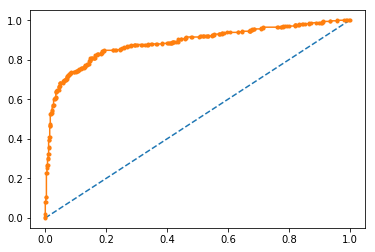

          fpr       tpr     1-fpr        tf  thresholds
117  0.173042  0.827485  0.826958  0.000527    0.233189


In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

print(model.evaluate(train_data, train_targets))
predict = model.predict(train_data)

auc = roc_auc_score(train_targets, predict)
print (f"AUC: {auc}")
fpr, tpr, thresholds = roc_curve(train_targets, predict)

plt.plot([0,1], [0,1], linestyle = '--')
plt.plot(fpr, tpr, marker = '.')
plt.show()

i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index = i), 'tpr': pd.Series(tpr, index = i),
                   '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i),
                   'thresholds': pd.Series(thresholds, index = i)})
print(roc.iloc[(roc.tf-0).abs().argsort()[:1]])

In [38]:
prediction = model.predict(test_data)
cutoff = 0.40

from sklearn.preprocessing import Binarizer
binarizer=Binarizer(cutoff)
results=binarizer.fit_transform(prediction)
results=pd.DataFrame(results.astype(np.int32), columns = ['Survived'])
submittion = pd.read_csv('test.csv', usecols=[0])
submittion = pd.concat([submittion, results], axis = 1)
submittion.to_csv("submittion_2.csv", index = False, encoding = 'utf-8')

In [39]:
print(submittion.sample(5))

     PassengerId  Survived
311         1203         0
289         1181         0
241         1133         1
231         1123         1
60           952         0
